In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
# %matplotlib qt
%matplotlib inline
import pickle

In [2]:
def showImg(img):
    plt.imshow(img)
    plt.show()

## Find Chessboard Corners

In [4]:
# Set numb er of chessboard points
nx = 9
ny = 6
    
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in tqdm(enumerate(images)):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)

cv2.destroyAllWindows()

20it [00:03,  5.31it/s]


## Create mtx and dist matrices to Calibrate Camera

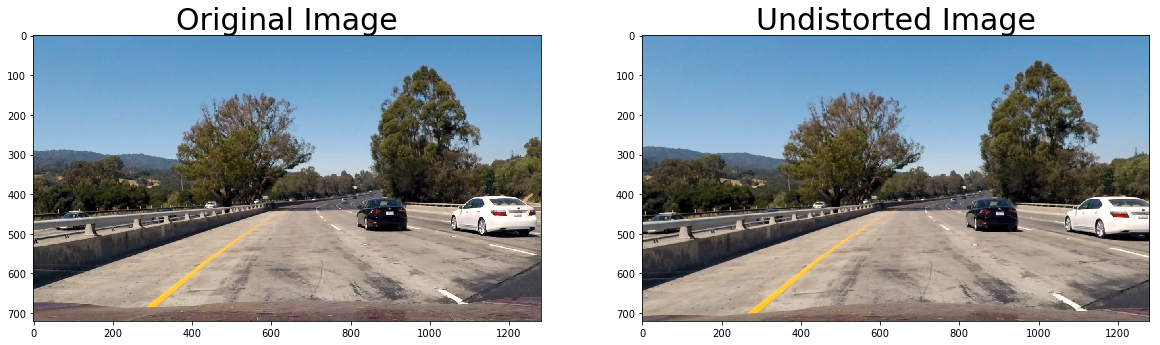

In [5]:
# Test undistortion on an image
img = cv2.imread('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
# pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## MAY BE ABLE TO JUST USE THIS CODE
## FOR GRADIENT THRESHOLDING
## AND COLORSPACES

In [12]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined = np.zeros_like(s_channel)
    combined[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined

## Tranform Image to Top View

In [9]:
def plotResult(original, new):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(cv2.cvtColor(new, cv2.COLOR_BGR2RGB))
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
%matplotlib qt
showImg(result)

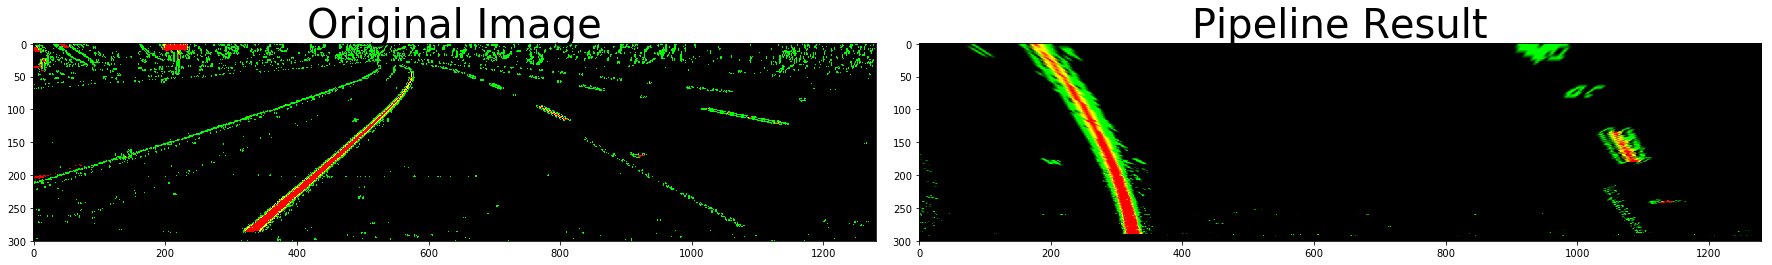

In [10]:

# Load Pickled mtx, dist and M for image calibration and transformation
pickle_file = open( "camera_cal/dist_pickle.p", "rb" )
dist_pickle = pickle.load( pickle_file )
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']

# Set number of chessboard points
nx = 9
ny = 6

#image = cv2.imread('test_images/test1.jpg')
image=result.astype(np.float32)

def reproject(image, nx, ny, mtx, dist ):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])

    if image.shape == (720, 1280, 3):
        # Working for full sized image
        src = np.float32([[300, 685], [625, 444], [717, 444], [1090, 677]])
        dst = np.float32([[300, 685], [300, 444], [1088, 444] ,[1088, 677]])
    else:
        # Cropped image
        src = np.float32([[300, 290] ,[572, 80  ] ,[756, 80 ] ,[1096, 290]])
        dst = np.float32([[300, 290] ,[300, 80 ] ,[1096, 80] ,[1096, 290]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return(warped)


new = reproject(image, nx, ny, mtx, dist )   
plotResult(image, new)

## FLOW CONTROL

6it [00:01,  4.03it/s]


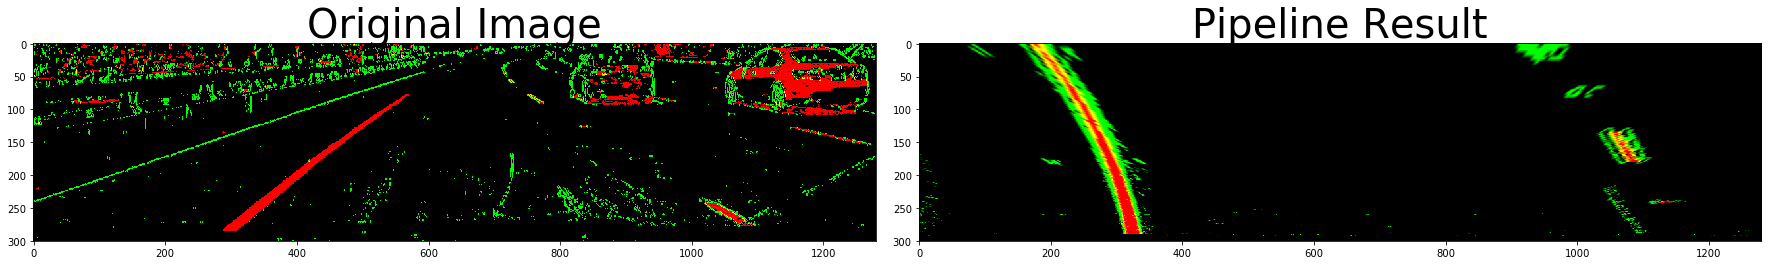

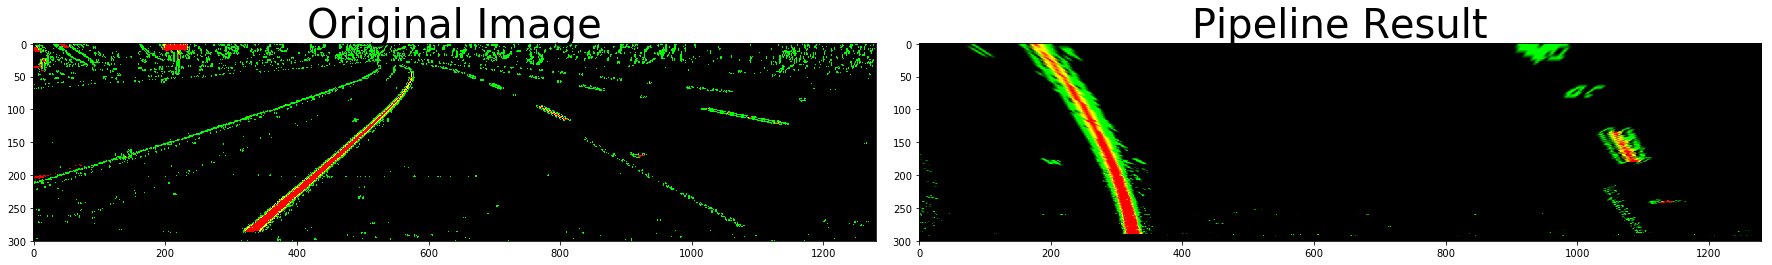

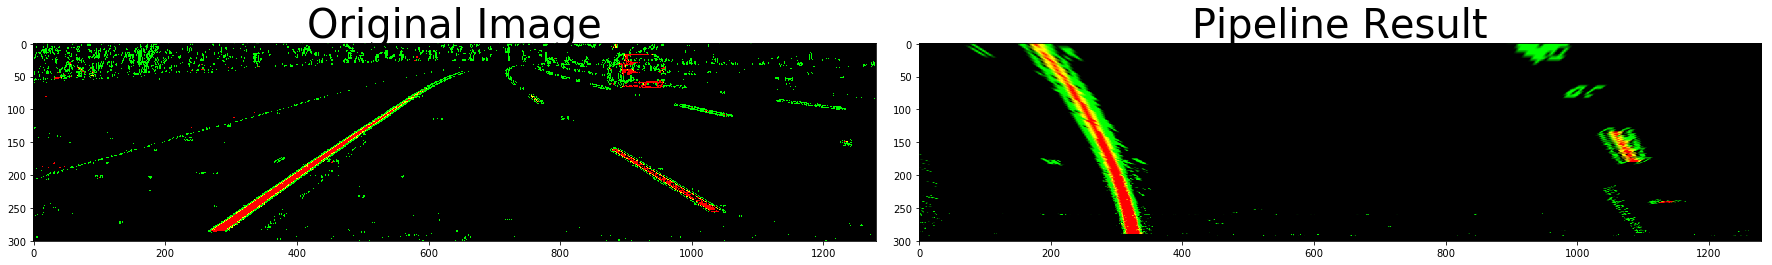

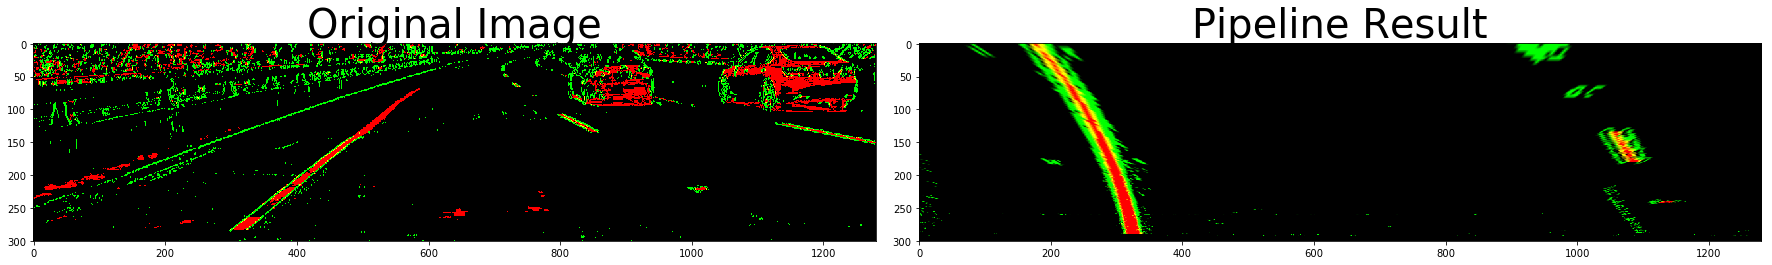

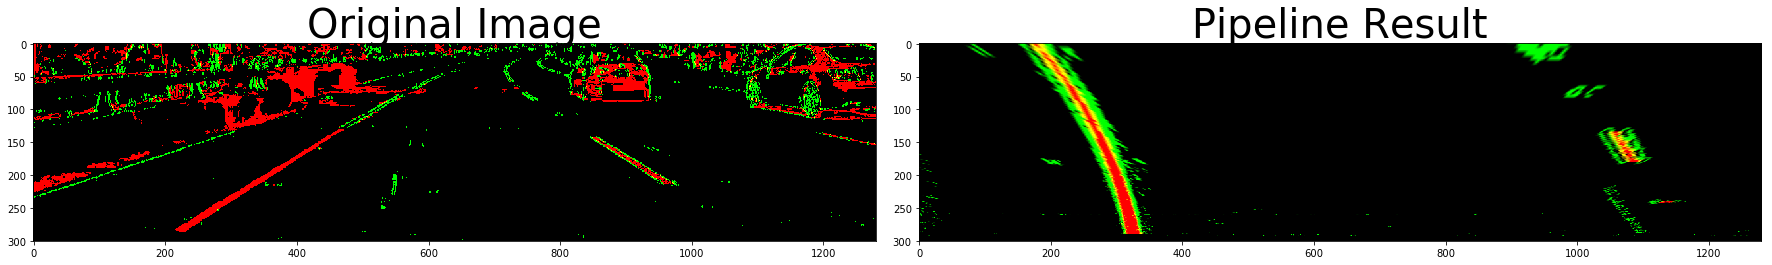

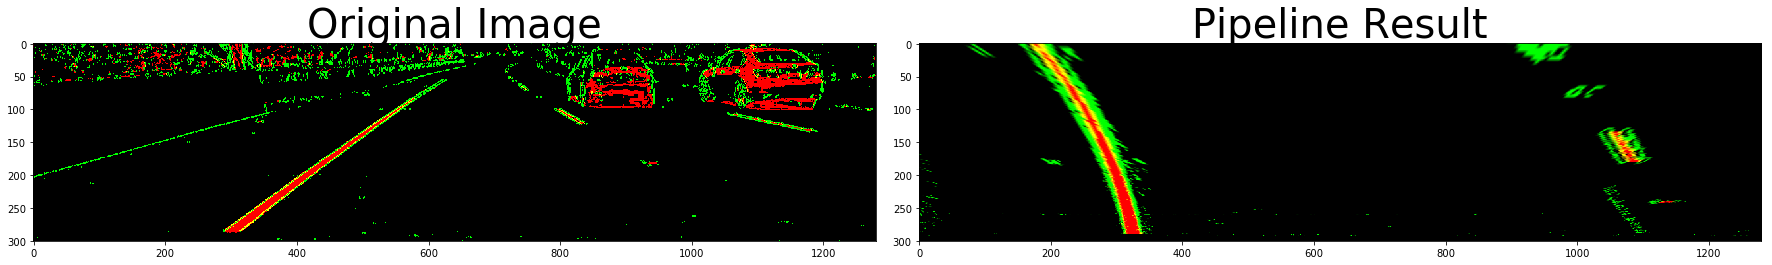

In [20]:
images = glob.glob('test_images/test*.jpg')
# Step through the list of images
for idx, fname in tqdm(enumerate(images)):
    image = cv2.imread(fname)
    # undistort and transform
    result, combined = pipeline(image[400:700, :])
    # Convert to float
    image=result.astype(np.float32)
    reproject(image, nx, ny, mtx, dist )   
    plotResult(image, new)




# Code Graveyard

## Appy calibration to images

In [61]:
# Applies Calibration
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
     
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    print('ret',ret)
    warped = undist
    M = []
    if ret == True:
        # If we found corners, draw them! (just for fun)
        #cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        img_size = (gray.shape[1], gray.shape[0])
        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                                     [img_size[0]-offset, img_size[1]-offset],
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

In [55]:
# Load Pickled mtx and dist for image calibration
pickle_file = open( "camera_cal/dist_pickle.p", "rb" )
dist_pickle = pickle.load( pickle_file )
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']

images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in tqdm(enumerate(images)):
    img = cv2.imread(fname)
    # undistort and transform
    warped, M = corners_unwarp(img, nx, ny, mtx, dist )
    cv2.imwrite('camera_cal/cal'+str(idx+1)+'_unwarp.jpg',warped)


20it [00:05,  3.98it/s]


## Apply calibration and save images

In [ ]:
# Load Pickled mtx and dist for image calibration
pickle_file = open( "camera_cal/dist_pickle.p", "rb" )
dist_pickle = pickle.load( pickle_file )
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']

images = glob.glob('test_images/test*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in tqdm(enumerate(images)):
    # open image
    img = cv2.imread(fname)
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/test'+str(idx+1)+'_undist.jpg',dst)



## Apply Perspective Transform to Test Images

In [71]:


# Load Pickled mtx, dist and M for image calibration and transformation
pickle_file = open( "camera_cal/dist_pickle.p", "rb" )
dist_pickle = pickle.load( pickle_file )
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']
M = pickle.load( open( "camera_cal/perpective_transform_M_pickle.p", "rb" ))

images = glob.glob('test_images/test*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in tqdm(enumerate(images)):
    # open image
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    # undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, img_size)
    cv2.imwrite('camera_cal/test'+str(idx+1)+'_warp.jpg',warped)




6it [00:00, 12.06it/s]


## Color/gradient thresholding

In [89]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255) ):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)   
    # Apply x or y gradient with and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output



##################################################
# Magnititude Thresholding - USEFUL CODE
##################################################
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


##################################################
# Gradient Direction for Feature Detection - USEFUL CODE
##################################################
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output



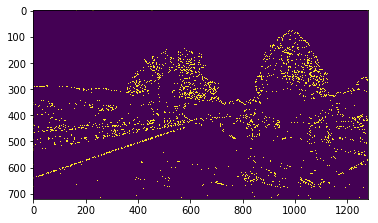

In [104]:
image = cv2.imread('test_images/test1.jpg')

# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(1, 1.3))

# For example, here is a selection for pixels where both the x and y gradients 
#meet the threshold criteria, or the gradient magnitude and direction 
# are both within their threshold values.
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Original Image
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.show()


plt.imshow(combined)
plt.show()


## Colour Pipline

0it [00:00, ?it/s]

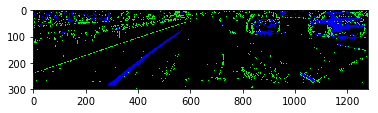

1it [00:00,  4.50it/s]

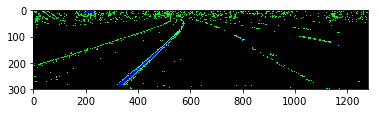

2it [00:00,  4.47it/s]

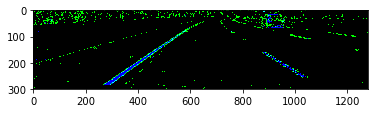

3it [00:00,  4.48it/s]

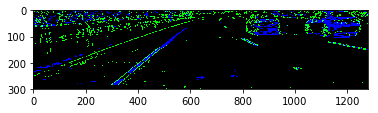

4it [00:00,  4.48it/s]

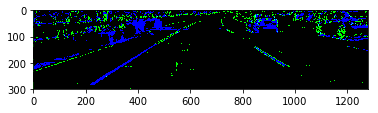

5it [00:01,  4.50it/s]

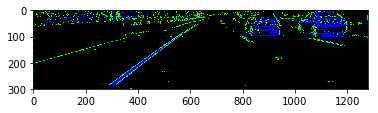

6it [00:01,  4.51it/s]


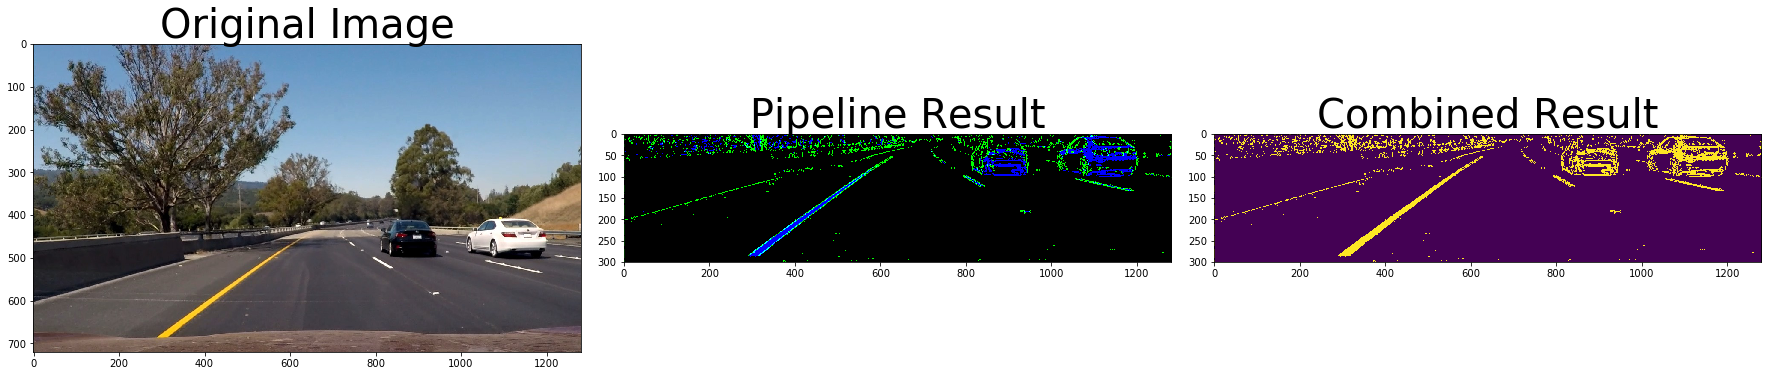

In [18]:
# One image only
# image = cv2.imread('test_images/test2.jpg')
# result, combined = pipeline(image[400:700, :])

images = glob.glob('test_images/test*.jpg')
# Step through the list of images
for idx, fname in tqdm(enumerate(images)):
    image = cv2.imread(fname)
    # undistort and transform
    result, combined = pipeline(image[400:700, :])
    showImg(result)
    #cv2.imwrite('out/test'+str(idx+1)+'_colour_thr.jpg', result)


############################################################
## MAKE A NICE PLOT
############################################################
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)

ax3.imshow(combined)
ax3.set_title('Combined Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

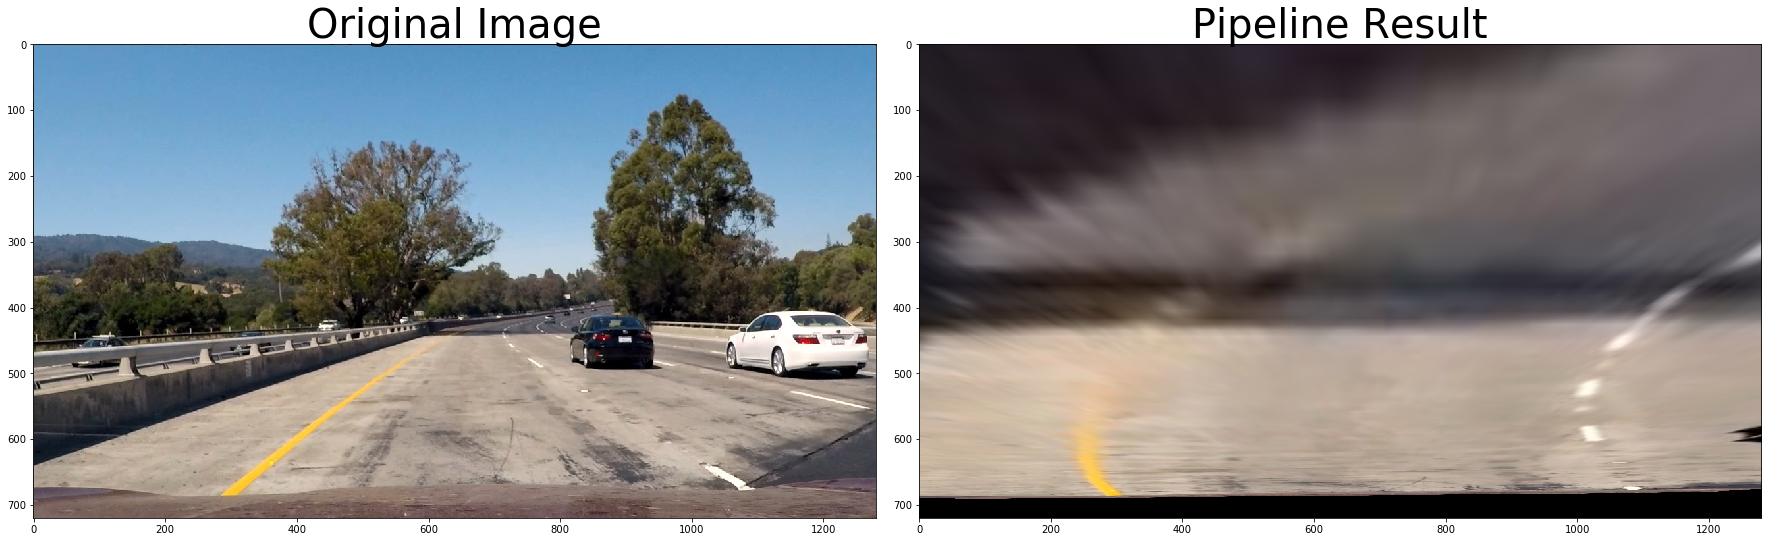

In [6]:
# Unused
# import pickle

# # Load Pickled mtx, dist and M for image calibration and transformation
# pickle_file = open( "camera_cal/dist_pickle.p", "rb" )
# dist_pickle = pickle.load( pickle_file )
# dist = dist_pickle['dist']
# mtx = dist_pickle['mtx']
# M = pickle.load( open( "camera_cal/perpective_transform_M_pickle.p", "rb" ))

# # Set numb er of chessboard points
# nx = 9
# ny = 6

# image = cv2.imread('test_images/test1.jpg')
# undist = cv2.undistort(image, mtx, dist, None, mtx)
# gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

# offset = 100 # offset for dst points
# img_size = (gray.shape[1], gray.shape[0])

# src = np.float32([[300, 685], [625, 444], [717, 444], [1090, 677]])
# dst = np.float32([[300, 685], [300, 444], [1088, 444] ,[1088, 677]])
# # Given src and dst points, calculate the perspective transform matrix
# M = cv2.getPerspectiveTransform(src, dst)
# # Warp the image using OpenCV warpPerspective()
# warped = cv2.warpPerspective(image, M, img_size)

# plotResult(image, warped)